### **1. Project Objective**

The central goal of this project is to explore and analyze a dataset comprising of forty soybean cultivars harvested over two consecutive seasons. The aim is to understand the factors influencing thousand seed weight (MHG) and grain yield (GY) among these cultivars, investigating seasonal changes in these metrics, and creating predictive models for estimating MHG in new cultivar types. Additionally, the project will also include cluster analysis to group similar cultivars based on their characteristics.

**Table of Contents**


1. Project Objective

2. Data Cleaning, Preprocessing and Feature Engineering  

3. Exploratory Data Analysis (EDA)

4. Most Important Factors for MHG

5. Most Important Factors for GY    

6. Seasonal Variations in MHG and GY

7. Creating Synthetic Data for New Cultivar Prediction    - join tables  , train 2 tables, test mean of features

8. Cluster Analysis

9. Model Selection and Tuning

10. Results

11. Conclusions

### **2. Data Cleaning, Preprocessing and Feature Engineering**

In [2]:
import pandas as pd

data_path = "./data/data.csv"
data = pd.read_csv(data_path)

print(data.head())
print(data.describe(include='all'))
print(data.info())


   Season    Cultivar  Repetition     PH    IFP    NLP     NGP   NGL   NS  \
0       1  NEO 760 CE           1  58.80  15.20   98.2  177.80  1.81  5.2   
1       1  NEO 760 CE           2  58.60  13.40  102.0  195.00  1.85  7.2   
2       1  NEO 760 CE           3  63.40  17.20  100.4  203.00  2.02  6.8   
3       1  NEO 760 CE           4  60.27  15.27  100.2  191.93  1.89  6.4   
4       1   MANU IPRO           1  81.20  18.00   98.8  173.00  1.75  7.4   

      MHG       GY  
0  152.20  3232.82  
1  141.69  3517.36  
2  148.81  3391.46  
3  148.50  3312.58  
4  145.59  3230.99  
            Season    Cultivar  Repetition          PH       IFP         NLP  \
count   320.000000         320  320.000000  320.000000  320.0000  320.000000   
unique         NaN          40         NaN         NaN       NaN         NaN   
top            NaN  NEO 760 CE         NaN         NaN       NaN         NaN   
freq           NaN           8         NaN         NaN       NaN         NaN   
mean      1

In [3]:
cultivars_path = './data/cultivars-description.ods'
cultivars_data = pd.read_excel(cultivars_path, engine='odf')

print(cultivars_data.head())
print(cultivars_data.describe(include='all'))
print(cultivars_data.info())

       Cultivars  Maturation group  Seeds per meter/linear  \
0  FTR 3190 IPRO               9.0                    12.5   
1  FTR 4288 IPRO               8.8                    11.0   
2   NK 8770 IPRO               8.7                    16.0   
3      M 8606I2X               8.6                    10.0   
4    M 8644 IPRO               8.6                    11.0   

   Density per meter/linear  
0                    250000  
1                    220000  
2                    320000  
3                    200000  
4                    220000  
            Cultivars  Maturation group  Seeds per meter/linear  \
count              40         40.000000               40.000000   
unique             40               NaN                     NaN   
top     FTR 3190 IPRO               NaN                     NaN   
freq                1               NaN                     NaN   
mean              NaN          8.042500               15.260000   
std               NaN          0.461818      

Ensuring column name and data type consistency, then making a function to find the closest name. Creating a list of names from cultivars_data for matching and replacing the 'Cultivar' names in data with the closest names from cultivars_data. This is all done so that the names of the cultivars in both datasets are consistent.

In [4]:
from fuzzywuzzy import process

cultivars_data.rename(columns={'Cultivars': 'Cultivar'}, inplace=True)

data['Cultivar'] = data['Cultivar'].astype(str)
cultivars_data['Cultivar'] = cultivars_data['Cultivar'].astype(str)

def find_closest_name(name, choices):
    return process.extractOne(name, choices)[0]

choices = cultivars_data['Cultivar'].tolist()

data['Cultivar'] = data['Cultivar'].apply(lambda x: find_closest_name(x, choices))

len(data["Cultivar"].unique())


40

Applying label encoding to 'Cultivar' columns in both datasets.

In [5]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder = LabelEncoder()

label_encoder.fit(cultivars_data['Cultivar'])

data['Cultivar'] = label_encoder.transform(data['Cultivar'])
cultivars_data['Cultivar'] = label_encoder.transform(cultivars_data['Cultivar'])

print(cultivars_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Cultivar                  40 non-null     int32  
 1   Maturation group          40 non-null     float64
 2   Seeds per meter/linear    40 non-null     float64
 3   Density per meter/linear  40 non-null     int64  
dtypes: float64(2), int32(1), int64(1)
memory usage: 1.2 KB
None


One-hot encoding to 'Season' and 'Repetition' and then concatenating the one-hot encoded columns back to the original dataframe.

In [6]:
one_hot_encoder = OneHotEncoder()
season_repetition_encoded = one_hot_encoder.fit_transform(data[['Season', 'Repetition']]).toarray()
season_repetition_encoded_df = pd.DataFrame(season_repetition_encoded, columns=one_hot_encoder.get_feature_names_out(['Season', 'Repetition']))

data = pd.concat([data, season_repetition_encoded_df], axis=1)
data.drop(['Season', 'Repetition'], axis=1, inplace=True)


print(data.head())
print(data.describe(include='all'))
print(data.info())

   Cultivar     PH    IFP    NLP     NGP   NGL   NS     MHG       GY  \
0        31  58.80  15.20   98.2  177.80  1.81  5.2  152.20  3232.82   
1        31  58.60  13.40  102.0  195.00  1.85  7.2  141.69  3517.36   
2        31  63.40  17.20  100.4  203.00  2.02  6.8  148.81  3391.46   
3        31  60.27  15.27  100.2  191.93  1.89  6.4  148.50  3312.58   
4        29  81.20  18.00   98.8  173.00  1.75  7.4  145.59  3230.99   

   Season_1  Season_2  Repetition_1  Repetition_2  Repetition_3  Repetition_4  
0       1.0       0.0           1.0           0.0           0.0           0.0  
1       1.0       0.0           0.0           1.0           0.0           0.0  
2       1.0       0.0           0.0           0.0           1.0           0.0  
3       1.0       0.0           0.0           0.0           0.0           1.0  
4       1.0       0.0           1.0           0.0           0.0           0.0  
         Cultivar          PH       IFP         NLP         NGP         NGL  \
count  3

### **3. Exploratory Data Analysis (EDA)**

Making descriptive statistics, distribution analysis with histograms and box plots for outliers and a correlation matrix.

         Cultivar          PH       IFP         NLP         NGP         NGL  \
count  320.000000  320.000000  320.0000  320.000000  320.000000  320.000000   
mean    19.500000   68.386781   15.4650   59.088313  135.085844    2.290844   
std     11.561475    8.958194    3.0243   20.068187   60.494529    0.840116   
min      0.000000   47.600000    7.2000   20.200000   47.800000    0.940000   
25%      9.750000   62.950000   13.6000   44.350000   95.052500    2.000000   
50%     19.500000   67.200000   15.6000   54.500000  123.000000    2.280000   
75%     29.250000   74.347500   17.3300   71.220000  161.350000    2.480000   
max     39.000000   94.800000   26.4000  123.000000  683.400000   14.860000   

               NS         MHG           GY    Season_1    Season_2  \
count  320.000000  320.000000   320.000000  320.000000  320.000000   
mean     4.071656  168.322313  3418.553794    0.500000    0.500000   
std      1.474531   19.625566   503.003602    0.500783    0.500783   
min     

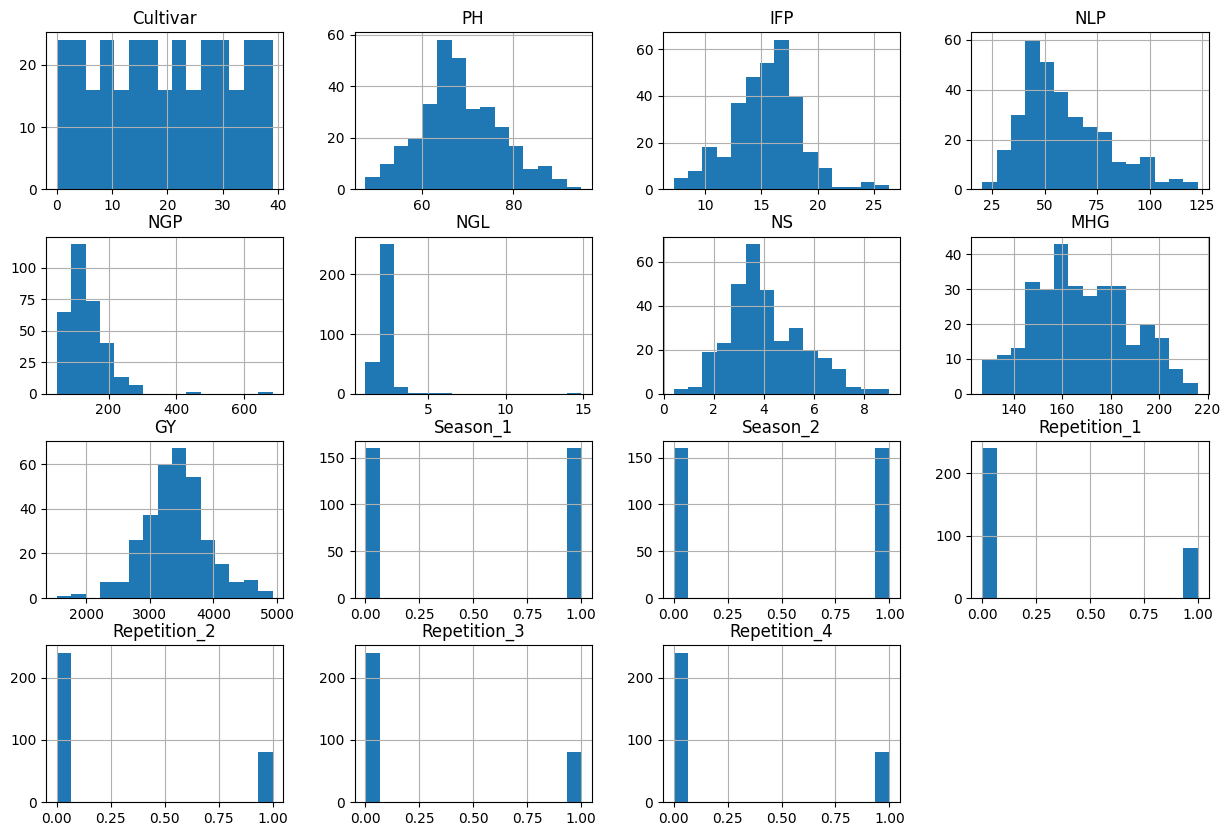

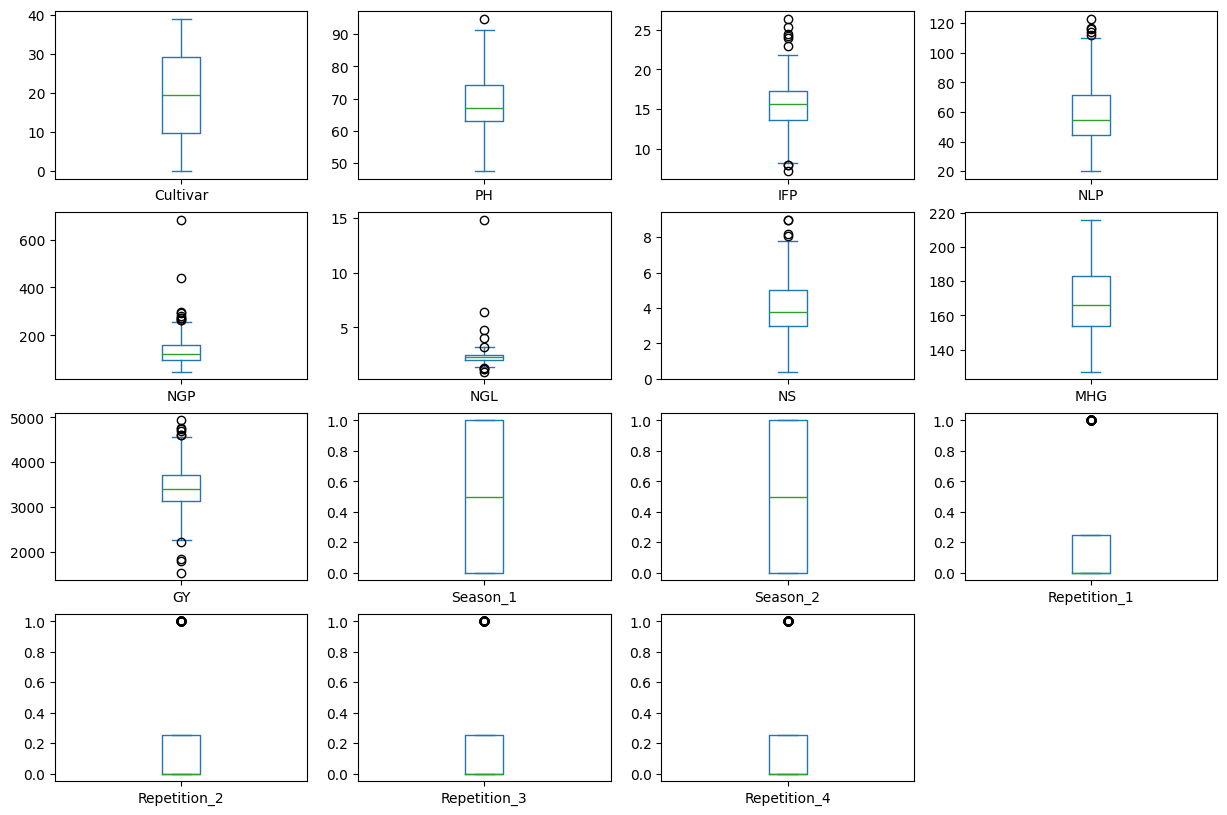

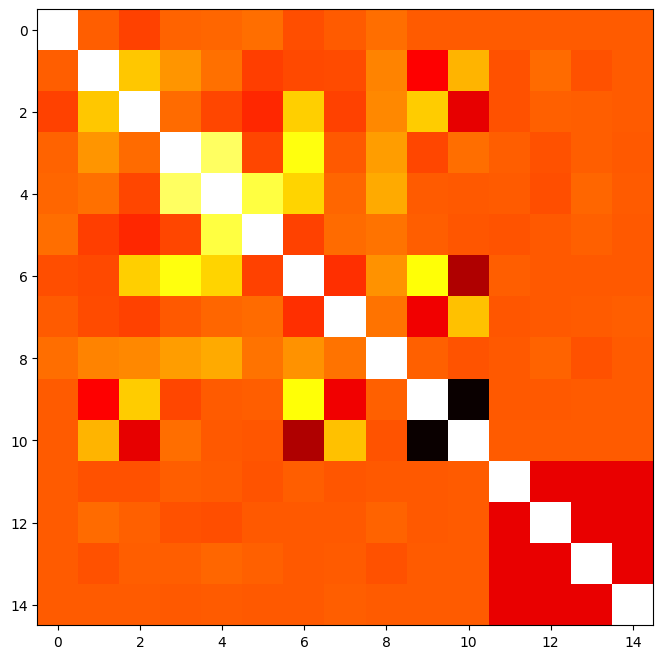

In [9]:
import matplotlib.pyplot as plt

print(data.describe())
print(cultivars_data.describe())

data.hist(bins=15, figsize=(15, 10), layout=(4, 4))
plt.show()

data.plot(kind='box', subplots=True, layout=(4,4), figsize=(15,10))
plt.show()

correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='hot')
plt.show()


### **4. Most Important Factors for MHG**

Finding most important factors for MHG by using correlation matrix.

In [10]:
correlation_matrix = data.corr()

mhg_correlations = correlation_matrix['MHG'].sort_values(ascending=False)

print(mhg_correlations)

MHG             1.000000
Season_2        0.307912
GY              0.074552
NGL             0.051604
NGP             0.032085
Repetition_4    0.013368
Cultivar        0.007687
Repetition_3    0.000665
NLP            -0.000687
Repetition_2   -0.006090
Repetition_1   -0.007942
PH             -0.046618
IFP            -0.071123
NS             -0.129252
Season_1       -0.307912
Name: MHG, dtype: float64


Finding most important factors for MHG by using Linear Regression.

In [12]:
from sklearn.linear_model import LinearRegression

X = data.drop('MHG', axis=1)
y = data['MHG']

model = LinearRegression()
model.fit(X, y)

feature_importance = pd.DataFrame(model.coef_, index=X.columns, columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)

print(feature_importance)

Feature importances via Linear Regression Coefficients:
              Coefficient
Season_2         8.460868
IFP              0.811865
NS               0.545273
Repetition_4     0.437860
Repetition_2     0.040362
Cultivar         0.026216
NGP              0.025830
GY               0.003169
NGL             -0.015632
NLP             -0.086806
Repetition_3    -0.164502
Repetition_1    -0.313720
PH              -0.441544
Season_1        -8.460868


According to the correlation matrix, the most important factors for "MHG" are "Season_2", "GY" and "NGL". Also "Season_1" has a strong negative influence. From the perspective of the Linear Regression, the highest positive
coefficient is "Season_2", followed by "IFP", while the highest negative coefficient is "Season_1". Overall,
it is showed that the "Season_2" and "Season_1" features play the most important role in determining "MHG".

### **5. Most Important Factors for GY**

Finding most important factors for GY by using correlation matrix.

In [13]:
correlation_matrix = data.corr()

mhg_correlations = correlation_matrix['GY'].sort_values(ascending=False)

print(mhg_correlations)

GY              1.000000
NGP             0.238883
NLP             0.198741
NS              0.167022
IFP             0.139090
PH              0.123281
NGL             0.077404
MHG             0.074552
Cultivar        0.059470
Repetition_2    0.024874
Season_1        0.019710
Repetition_4    0.005800
Repetition_1   -0.002183
Season_2       -0.019710
Repetition_3   -0.028491
Name: GY, dtype: float64


Finding most important factors for GY by using Linear Regression.

In [14]:
X = data.drop('GY', axis=1)
y = data['GY']

model = LinearRegression()
model.fit(X, y)

feature_importance = pd.DataFrame(model.coef_, index=X.columns, columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)

print(feature_importance)

              Coefficient
Repetition_2    28.119014
NS              23.087045
IFP             19.351107
Season_2         9.513983
Repetition_4     4.054777
NGP              4.008977
PH               3.990724
Cultivar         3.126704
MHG              2.154453
Repetition_1    -0.048369
NLP             -4.980415
Season_1        -9.513983
Repetition_3   -32.125421
NGL           -128.153083


According to the correlation matrix, the most important factors for "GY" are "NGP", "NLP" and "NS". From the perspective of the Linear Regression, the highest positive coefficient is "Repetition_2", followed by "NS" and "IFP", while the highest negative coefficients are "NGL" and "Repetition_3". Overall, it is showed that the "NGL" feature plays the most important role in determining "GY", while "Repetition_2" , "Repetition_3", "NS", "IFP" and "NGP" follow close by.

### **6. Seasonal Variations in MHG and GY**

First fiter data for "Season_1" and "Season_2", then compute means for MHG and GY in each season and finally
calculate the deltas.

In [17]:
season_1_data = data[data['Season_1'] == 1]
season_2_data = data[data['Season_2'] == 1]

mhg_season_1 = season_1_data['MHG'].mean()
mhg_season_2 = season_2_data['MHG'].mean()
gy_season_1 = season_1_data['GY'].mean()
gy_season_2 = season_2_data['GY'].mean()

delta_mhg = mhg_season_2 - mhg_season_1
delta_gy = gy_season_2 - gy_season_1

print(delta_mhg)
print(delta_gy)


12.067000000000007
-19.797286650000842


The output shows that "MHG" increases from "Season_1" to "Season_2", while "GY" decreases.

### **7. Creating Synthetic Data for New Cultivar Prediction**